# Рейтинг-система для спортивного «Что? Где? Когда?».

![](logo.png)

Продвинутое машинное обучение: ДЗ 2<br>
Задание: [link](https://logic.pdmi.ras.ru/~sergey/teaching/mademl2021.html)<br>
Выполнил: **Полянских Сергей**, март 2021

1. [Данные](#1.-Данные)
2. [Ранжирование](#2.-Ранжирование)
3. [Бейзлайн](#3.-Бейзлайн)
  1. [Очень простая модель](#1.-Очень-простая-модель)
  2. [Логрегрессия](#2.-Логрегрессия)
4. [EM-алгоритм](#4.-EM-алгоритм)
5. [Рейтинг турниров](#5.-Рейтинг-турниров)
6. [Игроки](#6.-Игроки)
  1. [Наивный рейтинг](#Наивный-рейтинг)
  2. [Рейтинг с отсечкой](#Рейтинг-с-отсечкой)
  3. [Софт-рейтинг модель](#Софт-рейтинг-модель)
7. [Динамические-рейтинги](#7.-Динамические-рейтинги)
  1. [Обучение на всех данных](#Обучение-на-всех-данных)
  1. [Скользящий рейтинг](#Скользящий-рейтинг)
  1. [Байесовский рейтинг](#Байесовский-рейтинг)
8. [Выводы](#Выводы)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta

from utils import load_players, load_tournaments, load_results
from utils import mean_correlation_score, top_score
from utils import prepare_sparse_data, get_player_questioncount, lr_decay, logloss, sigmoid
from utils import CustomLogisticRegression
from utils import plot_game_ratings_hist, plot_example

## 1. Данные

Выбираем турниры, в которых есть данные о составах команд и повопросных результатах.
Некорректные данные фильтруем. 

Тренировочный набор: турниры с dateStart из 2019 года,<br>
Тестовый набор: турниры с dateStart из 2020 года.

Здесь и далее вынесем вспомогательные функции по загрузке данных, отрисовке и т.п. в скрипт utils.py. В ноутбуке оставим только наиболее важный код исследуемых моделей.

**Игроки**

In [2]:
players = load_players('data/players.pkl')
players.head()

,id,name
0,1,Алексей Абабилов
1,10,Игорь Абалов
2,11,Наталья Абалымова
3,12,Артур Абальян
4,13,Эрик Абальян


**Турниры**

In [3]:
tournaments = load_tournaments('data/tournaments.pkl')
tournaments.head()

,id,name,year,type
0,1,Чемпионат Южного Кавказа,2003,Обычный
1,2,Летние зори,2003,Обычный
2,3,Турнир в Ижевске,2003,Обычный
3,4,Чемпионат Украины. Переходной этап,2003,Обычный
4,5,Бостонское чаепитие,2003,Обычный


**Результаты**

In [4]:
team_results = load_results('data/results.pkl', tournaments)
team_results.tail()

100%|██████████| 5528/5528 [00:07<00:00, 696.02it/s]  


,game_id,team_id,questions,wins,total,position,members,num_players,year
306674,6456,55612,"[1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, ...",20,39,3.0,"[138479, 80384, 133207, 95145, 121594, 133209]",6,2020
306675,6456,68457,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",19,39,4.5,[64129],1,2020
306676,6456,43261,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ...",19,39,4.5,"[111255, 166584, 135103, 103290, 103293]",5,2020
306677,6456,69918,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...",16,39,6.0,"[96552, 192899, 192900, 123238, 129706, 192901]",6,2020
306678,6456,63129,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...",13,39,7.0,"[165962, 154624, 224329]",3,2020


In [5]:
train_results = team_results[team_results['year'] == 2019]
test_results  = team_results[team_results['year'] == 2020]

## 2. Ранжирование

Ранжирование команд сделаем по **простому принципу**: рейтинг команды = сумме рейтингов отдельных ее игроков.<br>
Метрики возмем, какие указаны в задании - Спирмена и Кендалла. Они хорошо ловят монотонные зависимости - именно то, что нам нужно для сравнения рейтинговых систем.

Функции метрик также можно найти в utils.py

## 3. Бейзлайн

Сделаем ради интереса целых два бейзлайна.

Не смог отказать себе в искушении и наряду с логрегрессией предложить модель, которая будет еще проще - вообще без ML :).

### 1. Очень простая модель

Обучение:
- Рейтинг вопроса на турнире = доля ошибившихся в нем команд.
- Рейтинг команды на турнире = сумма рейтингов вопросов, на которые команда ответила верно.
- Рейтинг игрока = средний рейтинг команд, в которых он играл.
  
Инференс:
- Рейтинг команды = сумма рейтингов ее игроков.

In [6]:
class SimpleModel:
    def __init__(self):
        self.player_ratings = None

    def fit(self, data):
        team_results = data[['game_id', 'questions', 'members']].copy()
        team_results['team_rating'] = team_results.groupby('game_id')\
                                                  .apply(self._get_team_ratings)\
                                                  .explode()\
                                                  .values.astype(float)
        player_results = team_results.explode('members').rename({'members': 'player_id'}, axis=1)
        player_ratings = player_results.groupby('player_id').agg({'team_rating': 'mean'}).reset_index()
        player_ratings.rename({'team_rating': 'player_rating'}, axis=1, inplace=True)

        self.player_ratings = player_ratings

    def predict(self, data):
        result = data[['game_id', 'team_id', 'members']].explode('members')\
                                                        .rename({'members': 'player_id'}, axis=1)
        result = result.merge(self.player_ratings, on='player_id')
        result = result.groupby(['game_id', 'team_id'])['player_rating'].sum().reset_index()
        result.columns = ['game_id', 'team_id', 'team_rating']
        return result
    
    @staticmethod
    def _get_team_ratings(g):
        questions_mask = np.array(list(g['questions'].values))
        questions_ratings = 1 - questions_mask.mean(axis=0)
        team_ratings = (questions_mask * questions_ratings).sum(axis=1)
        return team_ratings

In [7]:
model = SimpleModel()
model.fit(train_results)
pred_results = model.predict(test_results)

In [8]:
mean_correlation_score(test_results, pred_results)

{'spearman': 0.696, 'kendall': 0.541}

Не так уж и плохо для такой простой модели. Метрики вполне укладываются в рекомендованные в задании диапазоны.

### 2. Логрегрессия

OHE для игроков и вопросов + Логрегрессия.

Имея ввиду следующее задание с EM алгоритмом сразу будем обучать модель не библиотечной логрегрессией, а кастомной (тоже в utils.py).

In [9]:
class LinearModel:
    def __init__(self, **kwargs):
        self.core = CustomLogisticRegression(**kwargs)
        self.player_ratings = None
        self.question_rating = None

    def fit(self, data, weights=None):
        print('prepare sparse data...')
        X, y, teams, players, player_inv_map, question_inv_map = prepare_sparse_data(data)
        if weights is not None:
            player_weights = pd.DataFrame({'player_id': players})
            player_weights = player_weights.merge(weights, on='player_id', how='left')
            weights = player_weights['weight'].fillna(0.0).values
        
        print(f'data: {X.shape}.\nfit logictic regression...')
        self.core.fit(X, y, weights)

        print('save model params...')
        n_players = len(player_inv_map)
        n_questions = len(question_inv_map)  
        theta = self.core.coef_[1:]
        
        self.player_ratings = pd.DataFrame({
            'player_id': [player_inv_map[i] for i in range(n_players)], 
            'player_rating': theta[:n_players]})
        self.question_ratings = pd.DataFrame({
            'question_id': [question_inv_map[i + n_players] for i in range(n_questions)], 
            'question_rating': theta[n_players:]})
        assert len(self.question_ratings) == n_questions
        
        print('done!')
    
    def predict(self, data):
        result = data[['game_id', 'team_id', 'members']].explode('members')\
                                                        .rename({'members': 'player_id'}, axis=1)
        result = result.merge(self.player_ratings, on='player_id', how='left')
        result = result.groupby(['game_id', 'team_id'])['player_rating'].sum().reset_index()
        result.columns = ['game_id', 'team_id', 'team_rating']
        return result

In [10]:
model = LinearModel(lr=15.0, num_iter=100000, batch_size=1000)
model.fit(train_results)

prepare sparse data...
data: (13787815, 83581).
fit logictic regression...


100%|██████████| 100000/100000 [17:56<00:00, 92.86it/s]


save model params...
done!


In [11]:
pred_results = model.predict(test_results)

In [12]:
mean_correlation_score(test_results, pred_results)

{'spearman': 0.754, 'kendall': 0.597}

Метрики неплохо выросли.

## 4. EM-алгоритм

Вероятностная модель с EM-обучением (подсмотрел в вашей статье).

Если бы игроки не переходили между командами, то способа узнать рейтинг каждого игрока в отдельности в принципе не существовало бы. Значит нужно учесть, в какой команде играет игрок. 

**Модель**

Пусть $p, q, t$ - индексы игроков, вопросов и команд соотвественно. Положим $x_{tq}$ - ответ команды $t$ на вопрос $q$ (значения - 0 или 1) - наблюдаемые переменные. Пусть далее $z_{pq}$ - ответ игрока $p$ на вопрос $q$ (значения - 0 или 1) - скрытые переменные. Параметры модели оставит теми же, что и раньше в логрегрессии: $\theta = (w_0, w, \tau)$ - один на всех bias $w_0$, вектор коэффициентов регрессии для игроков $w$ и вектор коэффициентов регрессии для вопросов $\tau$.

Чтобы введение скрытых переменных упрощало задачу, сделаем следующее **предположение**:
команда верно ответила тогда и только тогда, когда хотя бы один игрок верно ответил: 

$$
p(x_{tq} = 1 | z_{pq} = 1) = 1,
$$

$$
p(x_{tq} = 0 | z_{pq} = 1) = 0,
$$

$$
p(x_{tq} = 0) = \prod_{p\in t} p(z_{pq} = 0).
$$

**EM-алгоритм**

Согласно классическому формализму обучения вероятностных моделей задача максимизации правдоподобия

$$
p(x|\theta) = \sum_z p(x|z,\theta)p(z|\theta),
$$

$$
\log \prod_x p(x|\theta) = \sum_x\log\sum_zp(x|z,\theta)p(z|\theta) \rightarrow max_\theta
$$

решается заданием начального приближения для параметров $\theta_0$ и итерированием пары шагов:

1. **E-шаг** - решается в явном виде. Надо вычислить распределение скрытых переменных при условии наблюдаемых и текущего значения параметров $p(z|x,\theta_n)$. В нашем случае

$$
p(z_{pq}|x_{tq},\theta_n) = \frac{p(x_{tq}|z_{pq},\theta_n)p(z_{pq}|\theta)}{p(x_{tq}|\theta)},
$$

$$
p(z_{pq}=1|x_{tq}=0,\theta_n) = 0, 
$$

$$
p(z_{pq}=1|x_{tq}=1,\theta_n) = \frac{p(z_{pq} = 1|\theta)}{p(x_{tq} = 1|\theta)} = \frac{p(z_{pq}=1|\theta)}{1 - p(x_{tq} = 0|\theta)} = \frac{p(z_{pq}=1|\theta)}{1 - \prod_{s\in t} (1 - p(z_{sq} = 1|\theta)} = 
\frac{\sigma(w_0 + w_p + \tau_q)}{1 - \prod_{s\in t} (1 - \sigma(w_0 + w_s + \tau_q))}.
$$

2. **M-шаг** - выписываем правдоподобие и максимизируем его, рассматривая наденные выше оценки вероятностей как целевые метки для логрегрессии. Это оказывается эквивалентным обучению логрегрессии с подкорректированными метками.

In [13]:
class ExpectationMaximizationModel:
    def __init__(self, n_iters=10, **kwargs):
        self.core = CustomLogisticRegression(**kwargs)
        self.n_iters = n_iters
        self.player_ratings = None
        self.question_ratings = None

    def fit(self, train, valid):
        print('prepare sparse data...')
        X, y, teams, players, player_inv_map, question_inv_map = prepare_sparse_data(train)
        print(f'data: {X.shape}')
        prob_z = y
        
        for i in range(self.n_iters):
            print(f'---------- ITERATION #{i+1}/{self.n_iters} ----------')
            prob_z = self.e_step(X, y, prob_z, teams)
            self.m_step(prob_z, X, prob_z, player_inv_map, question_inv_map)
            self.validate(valid)
        
        print('done!')
        
    def e_step(self, X, y, prob_z, teams):
        if self.core.coef_ is None:
            return prob_z
        
        y_pred = pd.DataFrame({'team_id': teams, 'pred': self.core.predict_proba(X)})
        y_pred['sigm'] = sigmoid(y_pred['pred'].values)
        y_pred['neg_sigm'] = 1 - y_pred['sigm']
        y_pred['team_neg_sigm'] = y_pred.groupby('team_id') \
                                        .apply(lambda g: [g['neg_sigm'].prod()]*len(g)) \
                                        .reset_index() \
                                        .explode(0)[0].values
        y_pred['pred'] = y_pred['sigm'] / (1 - y_pred['team_neg_sigm'])
        y_pred.loc[y==0, 'pred'] = 0
        prob_z = y_pred['pred'].values.astype(float)
        
        del y_pred
                
        return prob_z

    def m_step(self, theta, X, y, player_inv_map, question_inv_map):
        print(f'fit logictic regression...')
        self.core.fit(X, y)

        print('save model params...')
        n_players = len(player_inv_map)
        n_questions = len(question_inv_map)  
        theta = self.core.coef_[1:]
        
        self.player_ratings = pd.DataFrame({
            'player_id': [player_inv_map[i] for i in range(n_players)], 
            'player_rating': theta[:n_players]})
        self.question_ratings = pd.DataFrame({
            'question_id': [question_inv_map[i + n_players] for i in range(n_questions)], 
            'question_rating': theta[n_players:]})
        assert len(self.question_ratings) == n_questions
        
    def validate(self, valid):
        pred_results = self.predict(valid)
        scores = mean_correlation_score(valid, pred_results)
        print('>>> scores:', scores)

    def predict(self, data):
        result = data[['game_id', 'team_id', 'members']].explode('members')\
                                                        .rename({'members': 'player_id'}, axis=1)
        result = result.merge(self.player_ratings, on='player_id', how='left')
        result = result.groupby(['game_id', 'team_id'])['player_rating'].sum().reset_index()
        result.columns = ['game_id', 'team_id', 'team_rating']
        return result

In [14]:
model = ExpectationMaximizationModel(n_iters=10, lr=15.0, num_iter=40000, batch_size=1000)
model.fit(train_results, test_results)

prepare sparse data...
data: (13787815, 83581)
---------- ITERATION #1/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [07:27<00:00, 89.42it/s]


save model params...
>>> scores: {'spearman': 0.737, 'kendall': 0.579}
---------- ITERATION #2/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:50<00:00, 97.49it/s] 


save model params...
>>> scores: {'spearman': 0.756, 'kendall': 0.597}
---------- ITERATION #3/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:08<00:00, 108.41it/s]


save model params...
>>> scores: {'spearman': 0.76, 'kendall': 0.602}
---------- ITERATION #4/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [07:02<00:00, 94.72it/s]


save model params...
>>> scores: {'spearman': 0.763, 'kendall': 0.605}
---------- ITERATION #5/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:59<00:00, 95.44it/s]


save model params...
>>> scores: {'spearman': 0.766, 'kendall': 0.607}
---------- ITERATION #6/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:58<00:00, 95.47it/s]


save model params...
>>> scores: {'spearman': 0.764, 'kendall': 0.607}
---------- ITERATION #7/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:59<00:00, 95.43it/s]


save model params...
>>> scores: {'spearman': 0.765, 'kendall': 0.608}
---------- ITERATION #8/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:55<00:00, 96.29it/s]


save model params...
>>> scores: {'spearman': 0.763, 'kendall': 0.604}
---------- ITERATION #9/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:53<00:00, 96.65it/s]


save model params...
>>> scores: {'spearman': 0.763, 'kendall': 0.605}
---------- ITERATION #10/10 ----------
fit logictic regression...


100%|██████████| 40000/40000 [06:52<00:00, 96.89it/s]


save model params...
>>> scores: {'spearman': 0.763, 'kendall': 0.605}
done!


Действительно, метрики немного растут от шага к шагу алгоритма.

## 5. Рейтинг турниров

Используем лучшую итерацию EM-алгоритма (последнюю) для построения рейтинга турниров по вопросам.<br>
Положим рейтинг турнира равным минус среднему рейтингу его вопросов. Итого - чем сложнее турнир, тем выше это значение.

In [15]:
question_ratings = model.question_ratings.copy()
question_ratings['game_id'] = question_ratings['question_id'].apply(lambda q: q // 1000)
question_ratings['question_id'] = question_ratings['question_id'] - 1000*question_ratings['game_id']
game_ratings = question_ratings.groupby('game_id')['question_rating'].mean().reset_index()
game_ratings.columns = ['game_id', 'game_rating']
game_ratings['game_rating'] = -game_ratings['game_rating']
game_ratings = game_ratings.merge(tournaments, left_on='game_id', right_on='id')
game_ratings.sort_values('game_rating', inplace=True)

In [16]:
game_ratings.head(25)

,game_id,game_rating,id,name,year,type
10,5013,-1.688772,5013,(а)Синхрон-lite. Лига старта. Эпизод V,2019,Асинхрон
6,5009,-1.586155,5009,(а)Синхрон-lite. Лига старта. Эпизод III,2019,Асинхрон
342,5698,-1.510042,5698,(а)Синхрон-lite. Лига старта. Эпизод VII,2019,Асинхрон
346,5702,-1.491487,5702,(а)Синхрон-lite. Лига старта. Эпизод IX,2019,Асинхрон
150,5457,-1.398955,5457,Студенческий чемпионат Калининградской области,2019,Обычный
8,5011,-1.394480,5011,(а)Синхрон-lite. Лига старта. Эпизод IV,2019,Асинхрон
348,5706,-1.386773,5706,(а)Синхрон-lite. Лига старта. Эпизод XI,2019,Асинхрон
347,5704,-1.376901,5704,(а)Синхрон-lite. Лига старта. Эпизод X,2019,Асинхрон
9,5012,-1.335080,5012,Школьный Синхрон-lite. Выпуск 2.5,2019,Асинхрон
62,5313,-1.330768,5313,(а)Синхрон-lite. Лига старта. Эпизод VI,2019,Асинхрон


In [17]:
game_ratings.tail(25)

,game_id,game_rating,id,name,year,type
117,5412,0.902527,5412,Серия Premier. Седьмая печать,2019,Синхрон
58,5303,0.976749,5303,Мемориал Дмитрия Коноваленко,2019,Обычный
498,5947,0.992736,5947,Чемпионат Мира. Этап 3. Группа С,2019,Обычный
501,5950,1.029759,5950,Чемпионат Мира. Финал. Группа С,2019,Обычный
124,5421,1.050126,5421,Львов зимой. Адвокат,2019,Синхрон
493,5942,1.054903,5942,Чемпионат Мира. Этап 2. Группа В,2019,Обычный
234,5563,1.061597,5563,Линч,2019,Синхрон
23,5098,1.064074,5098,"Ра-II: синхрон ""Борского корабела""",2019,Синхрон
156,5465,1.064378,5465,Чемпионат России,2019,Обычный
187,5501,1.066623,5501,Кубок Кайнозоя,2019,Синхрон


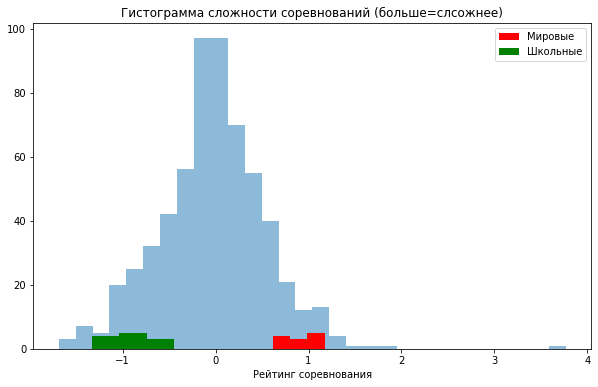

In [18]:
plot_game_ratings_hist(game_ratings)

Действительно, школьные соревнования ощутимо легче, чем мировые.

## 6. Игроки

Построим топ игроков по рейтингу, даваемому моделью.<br>
Чтобы была какая-то численная метрика, выгрузим топ 100 игроков на сегодняшний день с сайта и будем сравнивать с нашими том 100.

В качестве метрики возьмем сумму IoU нашего топ 100 и реального и корреляций Спирмена, Кендалла (для общих позиций):

$$
IoU(true_{100}, pred_{100}) = \frac{\# true_{100} \cap pred_{100}}{\# true_{100} \cup pred_{100}} \in [0, 1],
$$

$$
Corr(true_{100}, pred_{100}) = \frac{Spearman(true_{100}, pred_{100}) + 1}{4} + \frac{Kendall(true_{100}, pred_{100}) + 1}{4} + \frac{1}{2} \in [0,1]
$$

$$
Score(true_{100}, pred_{100}) = 0.8*IoU(true_{100}, pred_{100}) + 0.2*Corr(true_{100}, pred_{100}) \in [0, 1].
$$

Весовой коэффициент 0.8 при IoU позволит больше учитывать и контент рейтинга и меньше - саму сортировку. Таким образом мы учитываем, что **топ-100 игроков по этой системе действительно сильные, хотя точный порядок особого смысла не имеет**.

In [19]:
top100_real = pd.read_csv('data/top100.csv')
top100_real.head(10)

,place,player_rating,games_lastyear,games_total,player_id,name
0,1,8927,55,729,30152,Сорожкин Артём Сергеевич
1,3,8882,35,541,30270,Спешков Сергей Леонидович
2,3,8882,44,606,27822,Савченков Михаил Владимирович
3,3,8882,97,651,28751,Семушин Иван Николаевич
4,5,8864,21,504,27403,Руссо Максим Михайлович
5,6,8795,40,594,4270,Брутер Александра Владимировна
6,7,8766,105,741,18332,Либер Александр Витальевич
7,8,8591,18,427,18036,Левандовский Михаил Ильич
8,9,8586,50,678,6482,Галачян Ким Гагикович
9,10,8563,39,425,22799,Николенко Сергей Игоревич


### Наивный рейтинг

In [20]:
player_ratings = model.player_ratings.copy()
player_questioncount = get_player_questioncount(train_results)
player_ratings = player_ratings.merge(players, left_on='player_id', right_on='id') \
                               .merge(player_questioncount, on='player_id')
player_ratings.sort_values('player_rating', ascending=False, inplace=True)

top100_ours = player_ratings.iloc[:100, :].reset_index(drop=True)

In [21]:
top100_ours.head(25)

,player_id,player_rating,id,name,question_count
0,4270,2.527566,4270,Александра Брутер,2240
1,27822,2.519647,27822,Михаил Савченков,2666
2,27403,2.466334,27403,Максим Руссо,1796
3,28751,2.458650,28751,Иван Семушин,3071
4,22799,2.455613,22799,Сергей Николенко,1806
5,30270,2.414311,30270,Сергей Спешков,3017
6,30152,2.409691,30152,Артём Сорожкин,4006
7,18036,2.386758,18036,Михаил Левандовский,1113
8,20691,2.373067,20691,Станислав Мереминский,1370
9,13689,2.363609,13689,Дмитрий Карякин,1097


In [22]:
top_score(top100_real, top100_ours)

0.36497

Действительно, в топе довольно много неизвестных людей с малым число сыгранных вопросов. Рейтинг плохо коррелирует с тем, что на сайте.<br>
Постараемся улучшить ситуацию.

### Рейтинг с отсечкой

Попробуем разные отсечки, чтобы адекватно выбрать нужный уровень.<br>
Посмотрим, как это сказывается на нашей top-100 метрике.

100%|██████████| 2900/2900 [00:11<00:00, 242.91it/s]

Лучший порог: 1277


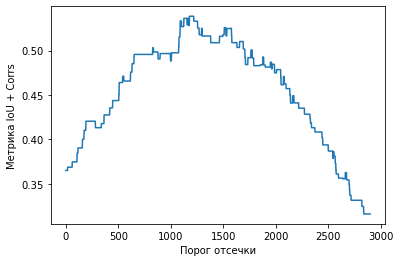

In [23]:
scores = []
best_score = 0
best_threshold = None

for t in tqdm(range(100, 3000)):
    threshold_ratings = player_ratings[player_ratings['question_count'] > t]
    top100_ours = threshold_ratings.iloc[:100, :]
    score = top_score(top100_real, top100_ours)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_threshold = t

print('Лучший порог:', best_threshold)

plt.plot(scores)
plt.xlabel('Порог отсечки')
plt.ylabel('Метрика IoU + Corrs')
plt.show()

Видно, что метрики некоторое время растут с увеличением отсечки. Выявляется даже максимум скора по отсечке - при количестве сыгранных вопросов = 1277.

Посмотрим на данные с предварительной отсечкой (выберем полученное выше значение $t=1277$).<br>
Заметим что обучающая выборка сократилась в 30 раз - с 57к до 2.3к. Сразу понятно, почему так делать, вообще говоря не стоит.

In [24]:
print('Кол-во игроков')
print('Было:', len(player_ratings))
print('Стало:', len(player_ratings[player_ratings['question_count'] > best_threshold]))

Кол-во игроков
Было: 55353
Стало: 2197


**Другое возможное решение:** обучать логрегрессию на выборке с весами. Весом объекта (игорока) можно считать число, близкое к 0, если он мало  играл, и близкое к  1, если много. Например, в простейшем варианте как-то так

$$
w(x) = 1 - \exp\left(-\frac{total\_questions(x)}{1484}\right).
$$

Так мы не потеряем бОльшую часть обучающей выборки, но повысим внимание модели именно к игрокам, сыгравшим солидное количество вопросов.

Реализуем этот вариант.

In [25]:
player_ratings['weight'] = player_ratings['question_count'].apply(lambda c: 1 - np.exp(-c/1277))

In [26]:
model = LinearModel(lr=15.0, num_iter=100000, batch_size=1000)
model.fit(train_results, weights=player_ratings)

prepare sparse data...
data: (13787815, 83581).
fit logictic regression...


100%|██████████| 100000/100000 [17:08<00:00, 97.19it/s]


save model params...
done!


In [27]:
pred_results = model.predict(test_results)

In [28]:
mean_correlation_score(test_results, pred_results)

{'spearman': 0.663, 'kendall': 0.512}

Стало хуже. Наверное, игроки среднего уровня и может даже и новички все-таки влияют на картину в целом.

**Вывод:**

Оба подхода - отсечка и взвешивание - в какой-то степени работают, но являются по сути полумерами к решению проблемы **холодного старта** - особого учета в рейтинге игроков, сыгравших мало игр. Основные проблемы здесь:
1. новый игрок находится вне рейтинга некоторое время
2. непонятно, из каких соображений выбирать отсечку: мало-плохо, много-тоже, посередине - ноунеймы близко к топу
3. после срабатывания порога (когда игрок наиграл достаточное число вопросов) он поадает в рейтинг/обучение и сразу же (жестко) начинает влиять на общий рейтинг. Желательно вводить игрока в рейтинг постепенно. В следующем пункте покажем, как это можно сделать.
4. в обоих случаях модель получается не универсальная: всегда приходится выбрасывать игроков по отсечке - и на этапе тренировки, и на этапе предсказаний.
5. не до конца понятно, что значит "не учитывать" игрока. Он все равно играет в команде. В рассмотренных случаях "не учитывать" фактически означало делать его рейтинг равным нулю.
6. даже разумная отсечка в 1484 сыгранных вопросов очень сильно просеивает игроков - с 57к до 2.3к, серьезно сокращая обучающую выборку.

### Софт-рейтинг модель

Так как EM-алгоритм максимизирует правдоподобие, то результат его работы - *фиксированный* вектор параметров-рейтингов.
Решить проблему "холодного старта" системы рейнгов в этом случае можно, пожалуй, только фильтрациями (по числу игр/вопросов/еще как-то).

Проблема "холодного старта" системы рейнгов поддается адекватному решению только в том случае, если мы имеем не вектор параметров-рейтингов, а вектор их распределений. Например, начав с каких-нибудь априорных распределений рейтингов игроков, мы могли бы найти (например MCMC семплированием) **апостериорные распределения рейтингов** игроков исходя из результатов их игр. В этом случае можно предложить **следующие решения**: 

1. брать в качестве рейтинга не среднее/медиану/моду(MAP) апостериорного распределения, я некоторый его t-й квантиль (t < 0.5).

2. брать в качестве рейтинга величину = среднее - t * среднекв. отклонение

В обоих случаях гиперпараметр $t$ можно подбирать на отложенной выборке. 

Продемонстрируем плюсы решения 1 на простом примере. Пусть игрок А из 3-х вопросов взял 2, а игрок из 300 вопросов взял 150 (сложность вопросов пока не учитываем). Что бы мы ни взяли: долю ответов, медиану, моду - рейтинг игрока A оказывается выше рейтинга B. 
Но если промоделировать рейтинг игроков бэта-распределением (как монетки), то получим следующие распределения:

$$
rank_A \sim Beta(3, 2), \quad rank_B \sim Beta(151, 151).
$$

Все меняется, если мы сравним их t-квантили (например, при $t=0.25$):

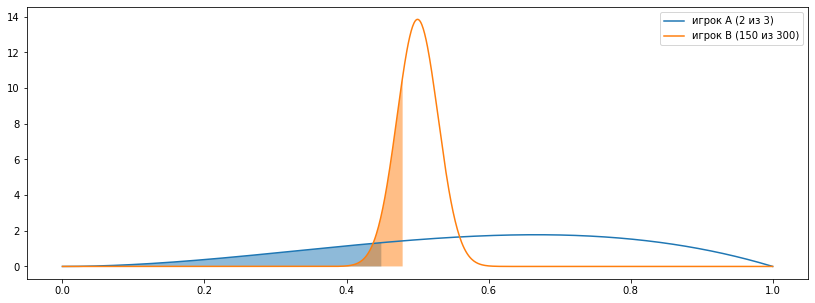

In [29]:
plot_example()

И это имеет смысл: беря квантиль, мы учитываем не только средние значения распределений, но и их дисперсию, которая тем ниже, чем больше игрок играет.

Продемонстрируем работоспособность такого подхода, предложив еще одну простую модель. Дабы не уходить в MCMC и подобные вещи, модель сделаем не строгую, а скорее простейшую демонстративную. Уже в этом случае удастся повысить качество классификации. В целом, модель будет похожа на самую первую - простейшую, но с распределениями вместо рейтингов.

Итак, предположим, что
1. рейтинг игрока - не одно число, а целое распределение.
2. пусть это $Beta$ распределение с параметрами: $\alpha - 1=$ средне-суммированный рейтинг взятых игроком вопросов (усредненный как в первой модели по всем командам, в которых выступал игрок), $\beta - 1=$ средне-суммированный рейтинг НЕ взятых игроком вопросов.
3. итоговый рейтинг игрока = t-й перцентиль этого распределения (t подберем на тесте)
4. итоговый рейтинг команды = сумма рейтингов ее игроков

In [30]:
class SoftRatingModel:
    def __init__(self, t):
        self.t = t
        self.player_ratings = None

    def fit(self, data):
        team_results = data[['game_id', 'questions', 'members']].copy()

        team_results['team_stats'] = \
            team_results.groupby('game_id')\
                        .apply(self._get_team_ratings)\
                        .explode()\
                        .values.tolist()
        team_results['team_rating'] = team_results['team_stats'].apply(lambda x: x[0])
        team_results['team_antirating'] = team_results['team_stats'].apply(lambda x: x[1])
        player_results = team_results.explode('members').rename({'members': 'player_id'}, axis=1)
        player_ratings = player_results.groupby('player_id').agg({'team_rating': 'sum', 
                                                                  'team_antirating': 'sum'}).reset_index()
        player_ratings.rename({'team_rating': 'player_rating', 
                               'team_antirating': 'player_antirating'}, axis=1, inplace=True)

        player_ratings['t-rating'] = player_ratings.apply(self._get_t_rating, axis=1)
        self.player_ratings = player_ratings

    def predict(self, data):
        result = data[['game_id', 'team_id', 'members']].explode('members')\
                                                        .rename({'members': 'player_id'}, axis=1)
        result = result.merge(self.player_ratings, on='player_id')
        result = result.groupby(['game_id', 'team_id'])['t-rating'].sum().reset_index()
        result.columns = ['game_id', 'team_id', 'team_rating']
        return result
    
    def _get_t_rating(self, r):
        a = r['player_rating'] + 1
        b = r['player_antirating'] + 1
        return beta.ppf(self.t, a, b)
    
    @staticmethod
    def _get_team_ratings(g):
        questions_mask = np.array(list(g['questions'].values))
        questions_ratings = 1 - questions_mask.mean(axis=0)
        team_ratings = (questions_mask * questions_ratings).sum(axis=1)
        team_antiratings = ((1 - questions_mask) * questions_ratings).sum(axis=1)

        return np.vstack((team_ratings, team_antiratings)).T

  0%|          | 0/101 [00:00<?, ?it/s]/home/sergey/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 101/101 [15:05<00:00,  8.96s/it]


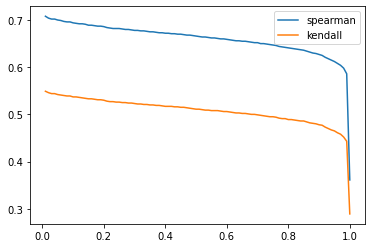

In [31]:
ss = []
ks = []
ts = np.arange(0, 1.01, 0.01)

for t in tqdm(ts):
    model = SoftRatingModel(t)
    model.fit(train_results)
    pred_results = model.predict(test_results)
    score = mean_correlation_score(test_results, pred_results)
    ss.append(score['spearman'])
    ks.append(score['kendall'])

plt.plot(ts, ss, label='spearman')
plt.plot(ts, ks, label='kendall')
plt.legend()
plt.show()

Действительно, это работает - метрики увеличиваются с уменьшением порога квантиля t. Итак, плюсы такого решения:
1. Не "жесткого" гиперпараметра порога, который непонятно как настраивать. "Мягкий" гоперпараметр квантиля можно вообще устремить к нулю - на ранжирование это повлияет скорее позитивно.
2. Игрок "мягко" вводится в общий рейтинг, сначала мало влияя на него, затем с ростом числа игр все сильнее.
3. Игрок имеет рейтинг с первых ирг (на самом деле и здесь я бы сделал небольшую отсечку, но уже совсем небольшую, чтобы нивелировать отголоски проблемы холодного старнта, отчасти присутствующие в любом решении)

## 7. Динамические рейтинги

### Обучение на всех данных

Сначала обучим модель на всех доступных данных (возьмем логрегрессию для простоты).<br>
UPD: на всех не вышло. Берем 2017-2019 года.

In [10]:
train_results_all = team_results[team_results['year'].isin([2017,2018,2019])]
train_results_all.shape

(159664, 9)

In [11]:
model_all = LinearModel(lr=15.0, num_iter=400000, batch_size=2000)
model_all.fit(train_results_all)

prepare sparse data...
data: (34265151, 169250).
fit logictic regression...


100%|██████████| 400000/400000 [2:49:03<00:00, 39.43it/s]  


save model params...
done!


In [12]:
pred_results = model_all.predict(test_results)

In [13]:
mean_correlation_score(test_results, pred_results)

{'spearman': 0.752, 'kendall': 0.594}

Метрики не выросли. Еле-еле дотянули то тех, что были, и то с бОльшим числом итераций.

### Скользящий рейтинг

Предложим следующию систему динамических рейтингов:
- пересчитываем рейтинги (=переобучаем нашу рейтинговую регрессию) с требуемой частотой, скажем, раз в месяц.
- в результате каждого нового пересчета для каждого игрока будет посчитан новый рейтинг: $r_{new}$ . Взвешенно суммируем его с предыдущим:

$$
r = \alpha r_{new} + (1 - \alpha) r_{prev}
$$

с некоторым $\alpha\in(0,1)$. Получаем скользящее среднее рейтингов игрока, которое ставит в приоритет (при больших $\alpha$) его последние результаты, но не забывает и об истории его рейтингов. По параметру $\alpha$ можно оптимизировать.

Попробуем этот подход. Для простоты сделаем обучение рейтингов не по месяцам, а по годам: 2017, 2018, 2019 и возьмем скользящее среднее результатов.

In [14]:
alpha = 0.5

In [15]:
years_ratings = pd.DataFrame({'player_id': []})

for year in [2017, 2018, 2019]:
    train_results_year = team_results[team_results['year'].isin([year])]
    print(f'START TRAIN FOR YEAR: {train_results_year.shape[0]}')
    print('--------------------------------------')

    model_year = LinearModel(lr=15.0, num_iter=200000, batch_size=1000)
    model_year.fit(train_results_year)
    years_ratings = years_ratings.merge(model_year.player_ratings, on='player_id', how='outer').fillna(0.0)
    years_ratings.rename({'player_rating': f'player_rating_{year}'}, axis=1, inplace=True)

START TRAIN FOR YEAR: 42912
--------------------------------------
prepare sparse data...
data: (9566519, 59786).
fit logictic regression...


100%|██████████| 200000/200000 [24:32<00:00, 135.82it/s]


save model params...
done!
START TRAIN FOR YEAR: 50000
--------------------------------------
prepare sparse data...
data: (10910817, 72149).
fit logictic regression...


100%|██████████| 200000/200000 [28:39<00:00, 116.29it/s]


save model params...
done!
START TRAIN FOR YEAR: 66752
--------------------------------------
prepare sparse data...
data: (13787815, 83581).
fit logictic regression...


100%|██████████| 200000/200000 [34:25<00:00, 96.83it/s]


save model params...
done!


In [16]:
player_rating = None

for year in [2017, 2018, 2019]:
    curr_rating = years_ratings[f'player_rating_{year}'].values
    player_rating = (1 - alpha)*player_rating + alpha*curr_rating if player_rating is not None else curr_rating
    
years_ratings['player_rating'] = player_rating

In [17]:
model_slide = LinearModel()
model_slide.player_ratings = years_ratings[['player_id', 'player_rating']]
pred_results = model_slide.predict(test_results)

In [18]:
mean_correlation_score(test_results, pred_results)

{'spearman': 0.746, 'kendall': 0.59}

Метрики не возросли. Увы.

### Байесовский рейтинг

Сама система баейсовского вывода естественным образом позволяет сделать динамические рейтинги, которые к тому же можно обновлять максимально динамично - после каждой игры. Если у нас будут распределения рейтингов вместо статичных чисел, то обновлять их можно будет обычной схемой bayesian update.

Из минусов такого решения - bayesian update рейтингов может быть очень трудозатратен: если распределения не вычисляются в явном виде, то придется считать интегралы. Если же удастся реализовать эту схему посредством сопряженных распределений, то все должно быть ок.

Как это сделать хорошо - надо думать. Нужно полностью менять модель, проводить эксперименты. В качестве демонстрации можно было бы использовать имплементированную выше модель SoftRatingModel, но я этого делать не стал - ноутбук и так уже сильно раздулся :). Идея довольно ясна - с приходом новых вопросов инкрементаются степени в бета-распределениях рейтингов, и дальше уже можно считать все, что захотим - например, пересчитывать сами рейтинги как t-квантили этих распределений.

## Выводы

Было рассмотрено 4 модели со своими достоинствами и недостатками:

- **Простая no-ML модель**: простота, неплохие метрики. Минусы - статичный рейтинг, метрики ниже, чем у других моделей, новички влияют на рейтинг.
- **Логрегрессия**: простота, почти топовые метрики. Минусы - статичный рейтинг, результаты игрока неотделимы от результатов команды, новички влияют на рейтинг.
- **EM-логрегрессия**: топовые метрики, результаты игрока отделяются от результатов команды. Минусы - статичный рейтинг, долго обучать, новички влияют на рейтинг.
- **"Байесовская" мягкая модель** (простое демо на самом деле) - неплохие метрики (выше, чем у простой модели), распределения на выходе, новички почти не влияют на рейтинг. Минусы - это демо идеи, а не реальная модель. Реальную было бы сложнее обучать и использовать.

**Общие выводы:**
- EM алгоритм действительно позволяет учесть скрытые переменные через наблюдаемые и показать (приближенно) силу игрока в отрыве от силы всей команды.
- Для рейтинговой системы скорее всего лучше подойдет полная байевская модель, дающая распределения рейтингов. Такой подход даст и регуляризацию, и естесственную возможность понизить рейтинг новичков. Кроме того он может дать естественный инструмент для расчете рейтингов в реал-тайм сразу после игр - с помощью байесовского обновления.
- Подходы для унижения новичков типа выбрасывания из рейтингов малосыгравших, взвешивания из с малым весом - практически не сработали.

<div style="visibility:hidden">
### Максимка
</div>

<div style="visibility:hidden">
ббоорпрбднолгорорр7н57
</div>